In [1]:
import carball
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
%matplotlib inline

In [2]:
from data import Calculated, Carball

data_manager = Calculated()

In [39]:
num_columns = 151
class GoalPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(num_columns, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )
    
    def forward(self, game_state):
        return self.layers(game_state)

In [49]:
def get_train_test_data(proto, dataframe):
    # Only from the perspective of the blue team (we'll switch them up)
    players = dataframe.columns.levels[0]
    columns = dataframe.columns.levels[1]
    teams = proto.teams
    team_map = {}
    for i, team in enumerate(teams):
        for player in team.player_ids:
            team_map[player.id] = int(team.is_orange)
    name_team_map = {p.name: p.is_orange for p in proto.players}
    
    sorted_players = sorted([p for p in players if p not in ['ball', 'game']], key=lambda x: name_team_map[x]) + ['ball', 'game']
    
    
    goal_teams = []
    goals = []
    for goal in proto.game_metadata.goals:
        goal_teams.append(team_map[goal.player_id.id])
        goals.append(goal.frame_number)
    
    # Get goal number
    goal_number = dataframe['game']['goal_number'].dropna()
    goal_team = goal_number.apply(lambda x: goal_teams[int(x)])
    goal_frame = goal_number.apply(lambda x: goals[int(x)])
    df = dataframe.copy()
    df['game', 'goal_team'] = goal_team.rename('goal_team')
    df['game', 'goal_frame'] = goal_frame.rename('goal_frame')
    df['game', 'frames_to_goal'] = (df['game']['goal_frame'] - df.index)
    df = df.dropna(subset=[('game','goal_team')])
    df = df[df['game']['frames_to_goal'] >= 0]
    df = df[sorted_players]
    actors = sorted_players[:-1]
    input_data = df[actors]
    if len(input_data.columns) != num_columns:
        return None, None, None, None
    
    # Set up data
    input = input_data.fillna(0).astype(float)
    output = df['game'][['goal_team', 'frames_to_goal']].values
    
#     print(input.shape, output.shape)
#     output = output.to_frame().merge((df['game']['goal_frame'] - df.index).to_frame(), left_index=True, right_index=True).values.reshape((-1, 1))
    rand = np.random.rand(output.shape[0])
    threshold = rand < 0.8
    input_train, input_test = input[threshold].values, input[~threshold].values
    output_train, output_test = output[threshold], output[~threshold]
    
    return input_train, input_test, output_train, output_test


# loss = nn.BCELoss()
loss = nn.MSELoss()
def train_on_proto_df(proto, df, model):
    input_train, input_test, output_train, output_test = get_train_test_data(proto, df)
    if input_train is None:
        print('data is none')
        return
    input_tensor = torch.from_numpy(input_train).float().cuda()
    output_tensor = torch.from_numpy(output_train).float().cuda()
#     print(output_train.shape, output_test.shape)
    print(proto.game_metadata.match_guid)
    for x in range(100):
        opt.zero_grad()
        predicted = model(input_tensor)
#         print("shapes", predicted.shape, output_tensor.shape)
        loss_val = loss(predicted, output_tensor)
        loss_val.backward()
        opt.step()
        if x % 30 == 0:
#             print(input_tensor.shape, predicted.shape, output_tensor.shape)
#             print('Loss:', loss_val)

            test_output = model(torch.from_numpy(input_test).float().cuda())
            output = test_output.cpu().detach().numpy()
            team_accuracy = (output[:, 0].round() == output_test[:, 0]).sum() / output.shape[0]
            frame_accuracy = (abs(output[:, 1] - output_test[:, 1]) < 30 * 1).sum() / output.shape[0]
#             print('Accuracy', (output == output_test).sum() / output.shape[0])
    return loss_val.cpu().data.numpy(), [team_accuracy, frame_accuracy]

In [50]:
model = GoalPredictor().cuda().train()
opt = optim.Adam(model.parameters(), lr=1e-4)
epochs = 25
epoch_losses = []
accuracy = []
for epoch in range(epochs):
    epoch_loss = []
    epoch_accuracy = []
    for n in range(1):
        for replay in data_manager.get_replay_list(num=100, page=n + 1):
            df = data_manager.get_pandas(replay)
            proto = data_manager.get_proto(replay)
            if df is None or proto is None:
                continue
            try:
                los, acc = train_on_proto_df(proto, df, model)
            except Exception as e:
                print(e)
            epoch_loss.append(los)
            epoch_accuracy.append(acc)
    epoch_losses.append(epoch_loss)
    accuracy.append(epoch_accuracy)

102826C011E8D35ACAF872B99C9B171C
11B1B9DC11E8C76341B40EB14097B559
6B939DCE11E8C76A460A159E61C00416
6F0BD7C611E8D360958401B82C9F5CBB
03C09A9611E8D3614A767EBE1E040DB9
723574E411E8D46DDDD3779F6FA86103
C095894A11E8C7EC4EA4D58095DACF62
D63069C211E8C7ED52DA2C95600D04F5
624C0ECA11E8C7EE3FB998A492002E75
EDCA727E11E8C7EFEF450BB27FA4632F
C8B1F06411E8C7F19F723F93DDB876BB
BFD401C211E8C7F09945B1BFA3A4312F
6A6D85B211E8C7FC9584B8982C9F5CBB
A694BFF411E8C7FE4F670EAA0180EC12
46C0895A11E8C7FE15AB67A17925C4DE
29833F5811E8C7FF60EFDB874B79BA5F
C60C46FC11E8C80030F80192613B6737
6F0AEDE611E8C7FF5CEB258F90E3C53A
0179BF1211E8C801177541936D034FCF
D7B3E22211E8C808889BB4B3F4BC8AE2
D94DBAF811E8C809CA89A09EB66CE599
1935705611E8C80BEDACB4B2D8DA96A8
5249E11611E8C80A6D96E2B66EC3989C
51B72A9C11E8C828B2DFDE8585912911
37BCF31E11E8C806F363299B46B62918
DFD64A4011E8D47866146B970729A5D6
8790CE8811E8C65DCEE7F0BD194B3F14
F122386811E8C5D215AB63887925C4DE
9404903411E8C5D9094DE6A656EE8CEF
207D9B7411E8C6561D94AD927D913D63
14206C3411

46E28ACC11E8CB1F1C8D2CACDDA7BA9C
08A2F47611E8CB20F055DBA2D16595B0
EB51F02C11E8CB1D2A6C08A6A4BFED02
C0568D1611E8CB210EA52AB3FB96DBC2
9A0EA14C11E8CB2223BA5AB489425810
EA04C21611E8CDAD48B06EBD71BE58A5
6D1D51DE11E8CB263BAAD79E83362FD6
DDB8757411E8CDAE1F3C38A57B43BB89
9CC43B7611E8CB28F0EC7ABC6EE3B5AE
DCCC0E9211E8CB28F6B213B5705CB0BC
4980445E11E8CB2984BB2B991A6F09FC
DEFAB02C11E8CB2A07E598BCEC8E432E
8DD5235611E8CDB174F0AE98B7956A0A
B4C2091C11E8CB2BD45C80A7D0C6BE61
BE3A23E211E8CDB2ED5B07B66D227AE6
0F758D0E11E8CB2F38B73A8D93F5F544
971CF75611E8CB2FCBFE33879DA27B6A
97480C4C11E8CDB5CBFE78A09DA27B6A
D85FE50C11E8CDB4A86F8F947AC938C8
D2989F7811E8CDB5F0EC57826EE3B5AE
5EC78A1411E8CDBAC23C04BFCFA9171F
BBCA743211E8CDBB99C23ABC5776FF5B
1DD9FD6E11E8CB3C445ACBA06F5EF3F1
734609BC11E8CB3EAAB6D091AABD8C0B
D47E802A11E8CDBD2B00EA95C160D466
478F3B1C11E8CDBFCB19FF9EDEE4DFF5
5F8D7BBE11E8CB4106B06CB5CFA29187
B7F1FB2011E8CB433863308B893AE1C5
0F26997611E8C4DE6F9284B015A8A97B
B999CB8611E8CB45E1F51FA837901B26
49DDF75C11

6797CA2011E8D56A2B0029A8C160D466
C54F33DC11E8D56BD67A059478296A08
01F84DFE11E8D56DDDD368B06FA86103
0D73744A11E8D56F1775CFBD6D034FCF
E22B9EEC11E8D56F88D2E4A196CEB42B
11C2674E11E8D5701F3C46A07B43BB89
EA9E659011E8D570EDAC3FB7D8DA96A8
D8DD2A3411E8D571003E63A97E06B85B
86093B4411E8D5723CDB9EB71737A86E
04BF16AC11E8D573E1F5948A37901B26
69E86FE811E8D5774B9A57883EC41588
9B7DF70E11E8D57BB2DF06B985912911
0972E61011E8D57D47B6DD91D3AEA3D3
2B5F9F5A11E8D57F3863C682893AE1C5
0E0B05B611E8D584396D9C9C68244BC6
B7D74F6411E8D589DCB49180DA7601F9
3CF363EC11E8D58D43F8049837BB68A4
8CA4AD9E11E8D5901D949E957D913D63
BA04B35A11E8D5A0C11EB99E5E677929
A4014CC011E8D5A1F5C43F90BCD7229C
D3FFC18E11E8D602396D928568244BC6
33D54D5A11E8D62AEDE95AB2429A32CD
D3B69E0E11E8D62BCCE01088B78C084D
7C30CF2811E8D62C84241DB372A1FFC1
DB30384211E8D62CCAF883879C9B171C
A72B0A2211E8D631DE5EB6988C50DEBA
08062F7211E8D63556613CB5B3C35066
D9E3E17411E8D63507E52E8CEC8E432E
6A616A9A11E8D63797F096A9BA7C9F3F
7DB00A9611E8D63E47A2A09ED253EF33
BA387DD611

E5F4FB7A11E8DBFCF249869AA76F5C8B
E81164A611E8DBFDAAB6208DAABD8C0B
A6C7D38211E8DC063BAAE4A683362FD6
C6B16C1C11E8DC06958410902C9F5CBB
0CDD48F411E8DC080C9C17AA93EEA1E6
D7E2D62611E8DC139F722095DDB876BB
CE4C8D3411E8DC398267FE9CA47CA8FD
ACC1E67211E8DC49FA2D88A41B2340C0
6293E5D011E8DC5F6996E6B2EA63DF0F
F2C4210611E8DC788ACDAC857597FDD4
AF2E3E3811E8DC9435C305B251CD5D38
9BCD1B5611E8DC9573BBAAA748F85957
65228E7A11E8DC9955896AAFF4CBF7D5
3575805C11E8DC98F1757290284E6B98
AEB83E6611E8DC9647B6F998D3AEA3D3
F880CDCA11E8DC9FCC4175AD6B37926C
13A6E5E011E8DCC25A6E5B957FA316B0
FA8C05EC11E8DCC4CBFEA5BA9DA27B6A
2145F7E411E8DCCD31230EBE5C55065A
93EE0C8E11E8DCD0068A0A89098F0CE2
0E3E9CE611E8DCD2B03AD3B78F6C9447
792E65CE11E8DCD51EA776AC664E36BA
E6A6080611E8DD1511E94A9893B724A9
F203D3F011E8DD14331B2788FAB670CF
130E674C11E8DD1D122F969D6FD9AA21
738F1D4011E8DD37E1F591A137901B26
256751DE11E8DD3AF363ABA946B62918
AEEF7FAC11E8DD36B17DB087B9532C19
37AAB96611E8DD4A068A6A87098F0CE2
261CF7E811E8DD4CA3B2E481E5965C19
0611D00E11

F98BE07E11E8D3DF6940FEA4A37BC12B
F507105011E8D3DFF363419446B62918
3CE6222611E8C990CA8924B4B66CE599
962963FC11E8D3E515AB8DB77925C4DE
E157FBC611E8C996A127DEB75CEED59D
E1BD2B6611E8D3E8CB19BBBEDEE4DFF5
6089A00811E8C99B5743CB920E97E74B
8004C63211E8C99C1775E3A06D034FCF
377607E211E8C9A0D67AE7BE78296A08
946C405A11E8D4AA046F62AC6B943DD3
B7FC6FC611E8D4C955896892F4CBF7D5
C7F2D1D811E8C9B91F44408ACE788AEF
9259FFF411E8C9BBFB9AB5AC4F41F148
7D973FEE11E8C9B8B2DB4CBD2D537FA2
75134BCC11E8C9BA01C5B78003FEA074
70A0204011E8C9BC69408992A37BC12B
6E6E026811E8D4A98A29A4BAE8FBC013
F5FD979011E8C9D036C0059066B5B600
BFBF1DE411E8D3FCBFC19CB87351C5B6
424D257211E8C9D4445ABC916F5EF3F1
F5FD979011E8C9D036C0059066B5B600
BFBF1DE411E8D3FCBFC19CB87351C5B6
424D257211E8C9D4445ABC916F5EF3F1
F0CE763A11E8D3FE2CC8A2B12D90E774
4B39295E11E8D4AD66146F830729A5D6
8C5393F411E8D401CA8983A1B66CE599
9381AF6A11E8D4AD2CC833BA2D90E774
BD1242E411E8D404D951B7AFBDA20AF6
B032ABD411E8D4060C9C0FAB93EEA1E6
80C01D0411E8D407A86FCD867AC938C8
B50CEE2E11

6300E38E11E8CCA01503708CB23ED87E
37FFA21211E8CCA315E034A5E1E2E2C4
F56527DC11E8CCAD06B0D6A9CFA29187
3935337E11E8CCCE6E05B38A63E6D63F
97EA723E11E8CCCF4EA4A3A095DACF62
79BCF11A11E8CCCFD67A5E8D78296A08
CF0EFA9A11E8CCD04C8D339DEDA7B09C
4569318611E8CCD38A296E97E8FBC013
3959895011E8CCD730F811A4613B6737
BC7FCD2C11E8CB69460ADA8B61C00416
5ACF47B411E8CB60BC11D5B2AF19E2AD
CDD44AEC11E8CB5CD8236F961C972E74
23E1142011E8CD0AA645D59951A4802F
485E906611E8CD0F7B42BCAC6A3A4A60
9DFB777011E8CE4331AF80A79357E8F3
2DD6EFF411E8CE45C204F699025A91F2
94D392F811E8CE4415E053AEE1E2E2C4
9F89200E11E8CE453B915B87D0FA03FE
3198CCCA11E8CD3706B03ABBCFA29187
42BA2E1211E8CD4C460A8B9C61C00416
7A04B15211E8CD4D31AF69889357E8F3
2FE1E91211E8CD5499EF2E96A9D8C6B3
3AA607BC11E8CD5D6940C4B8A37BC12B
60B15C2E11E8CD60AD165E996554FF96
26B7EC9811E8CD6C4A76D0871E040DB9
945AAF6E11E8D08D3CDB8E821737A86E
976F33D411E8CE60F055E9B1D16595B0
95B0BA6211E8CE70B2DF049E85912911
E438894611E8CE78DDD3D6A46FA86103
8400107411E8D4CEFB163A8082A3D4C9
95133F0011

51F96F1211E8D898CB1980BDDEE4DFF5
05D0051A11E8D8A295C6F5BC9226333D
B6E6F82011E8D89FFB164FA582A3D4C9
64FA446C11E8D8A0DE5E5EBF8C50DEBA
12EA317C11E8D8A1CCE051B5B78C084D
0C3C906211E8D8A2AC13B18CCBF30AF2
8E75DC8211E8D8A2FB167A9882A3D4C9
C638378A11E8D8AE31AF5C9A9357E8F3
E505D47411E8D8B31F3CF68C7B43BB89
A4111CEC11E8D8B007E5E087EC8E432E
C2F2C6BE11E8D8B1CCE07788B78C084D
2896277211E8D8B2CA891D8AB66CE599
AA3465F811E8D8B4F36D97AD95A970F4
04B357E011E8D8B63F94C786513C40BD
45B45D2011E8D8BB74F0DEA3B7956A0A
D674C00411E8D8BE208CA4AB736BCBEC
49B41C6A11E8D8BDF916AEB46E3E0D8C
4020701C11E8D8C85A6E219E7FA316B0
39BCB91A11E8D8C867A9269E13E6498A
666FC32E11E8D8CAFB16CE9F82A3D4C9
3417AED811E8D8EC7EF44E828BFB2691
AA0BE31411E8D90CBFC11AB07351C5B6
0200951211E8D915988AAFB44178846A
0089D1B611E8D9161EA714B4664E36BA
1990418A11E8D91CD95195B7BDA20AF6
957B634411E8D92E0774378EDB1F9E4B
D052F3B211E8D94F5661CEACB3C35066
9EB8F7D411E8D94ADD4F2595ED93D5D8
9740F36011E8D94C445A94B26F5EF3F1
81193BB811E8D953003E1B877E06B85B
BA0854E611

B28D9DD611E8BB7801F23E8287D06070
D6DD495E11E8CF44958409B22C9F5CBB
3F68DABE11E8CF466750D1A8F2D2FDCA
B5705D0411E8CF5004E508A6C70BA343
62C5E86611E8CF5B1775B7906D034FCF
B720229611E8CF650774A482DB1F9E4B
8DCFE50A11E8D16AA4D5B593381B22F2
8C352A5011E8D16C9B92C59BCE958C87
8D473CEC11E8D16E7045ABAE55A4F62F
07B3CDD411E8D0EC8424CDA172A1FFC1
498A6B9611E8D1733CDB7F951737A86E
F8C19E5E11E8D1877B4206966A3A4A60
CF43BAB611E8D188D95136B4BDA20AF6
CF43BAB611E8D188D95136B4BDA20AF6
E1962AEC11E8D0EC11E9A38F93B724A9
766FBE2211E8D18CA64BE69AD39CEC1D
6534932011E8D18DFB16A09782A3D4C9
58E14A1A11E8D23136C0E68C66B5B600
4239792411E8D18FF5C419B9BCD7229C
92D4A40A11E8BD1A69405287A37BC12B
01D05C6011E8D197F4241288EE4D099D
C2CFDE7C11E8D232CCE07CB0B78C084D
BDEDC10211E8D233EDE9AAA1429A32CD
EC4B4B5A11E8D1A2F5C414BFBCD7229C
152E0FC411E8D1A55288E29EC25E20E3
022CD8B411E8D1A6EDF110BB38FAFC7A
E59785FE11E8D1A638637E90893AE1C5
B7DFB8F411E8D1AEA283F598692A63D5
5E81B21611E8D1B4DE5E5F9C8C50DEBA
5CA5C1F211E8D1B57A565AABDFA85F6B
CB60451C11

B65AF18411E8CA96396D2DAB68244BC6
1C3F05F411E8C44C7A79F0A210B8E4A9
49B1954211E8C45BF6B265A5705CB0BC
0D69A8FE11E8D2480945BE90C3A4E12F
9CD576C211E8C4698E80F28C8982EB9B
data is none
'NoneType' object is not iterable
AA08E9B011E8C468396D189468244BC6
47EDE20611E8CFE1584531A3A5A43E2F
3B6EF03E11E8CFE5208C74A9736BCBEC
6CC008C411E8CFE74EA492A095DACF62
E90F515A11E8CFE7E639059ADD4705C1
84FCB74011E8C473F175B39D284E6B98
988E66CA11E8CFE87841EB8034DF59B2
99F5514011E8CFED4EA4F9B695DACF62
B95BCB5011E8CFFB3CDBAF901737A86E
B3C76D5011E8C49FB2DBB3922D537FA2
CBBCB22411E8C4AB6F92B28115A8A97B
E879CD1A11E8C4AC8ACD58877597FDD4
FD3B69E411E8D248A7091EA531A9144E
DD48904A11E8C64E8ACDD1B47597FDD4
E5F6C0AE11E8D017CEE749AD194B3F14
13FA31B011E8C6507ABADC96E3DA7507
B248847011E8C655BB6267BF327FF865
0172614811E8C4C507E57798EC8E432E
EED05F1611E8D07EC2046F83025A91F2
F240F57411E8C4CC8E80C9AE8982EB9B
788E5BDA11E8C4D2A0D1288CE224B5EA
60EA8A5211E8C4D3D40F00A11E6114F5
319250B611E8D07F906583B42ADC5625
BA003CFE11E8C654A4D5A9B3381B2

614497AA11E8C59F5BB81B9436B06309
C01B432A11E8C5A2177509866D034FCF
B957F6C211E8C5A85743C6920E97E74B
58E242B411E8C5AFE2864D9D24E68ECC
60E59F8A11E8C5ADCC016FAEB8BFECA0
2923AF1011E8C67FCCE089B4B78C084D
F50CEE0011E8D2525CEB739590E3C53A
64CAAE3211E8D0FDB2DF44BB85912911
6792B1C011E8C5B6D42E35AFA9813356
0E93435011E8D2549584138E2C9F5CBB
6B6F1C9011E8C681F1754E96284E6B98
BCE3211611E8D257082C6BB184251EFF
7392354211E8D25728D876B45A552586
FEE5A62011E8C199E045249EF5A4A62F
0A006E5211E8D4D5035A69BBB9C3C4DE
B5BDAFBA11E8D544E845798585A48E2F
22000ADC11E8D5467345579727A4A72F
C16AAE7C11E8D4D5B57A98A1E67B0A36
7F77D6E411E8D5478A299C93E8FBC013
6D55EC0411E8D2769C4540B00DA4E22F
79B71CE211E8D277A64BAAB0D39CEC1D
E799E71211E8C1A1D8233FA01C972E74
8AAF491411E8C1A3694017B8A37BC12B
A8FD524211E8D27B5743FE960E97E74B
C8DF7BCC11E8C1A4AAAE628B63166A34
B317976411E8D27CCB19ED82DEE4DFF5
7324552A11E8C1A6A709D38E31A9144E
BBD0163211E8D27D082CEFB784251EFF
ACA11E9411E8D27E331B978FFAB670CF
A751F40811E8D27F8ACDFD867597FDD4
0C76EDFE11

Text(0.5, 1.0, 'Loss')

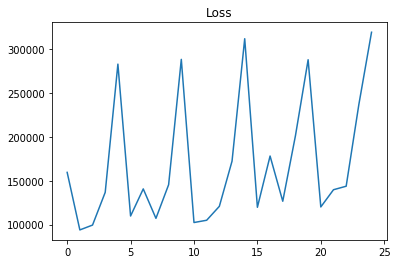

In [51]:
means = []
for l in epoch_losses:
    l = np.array(l)
    l = l[l != None]
    means.append(l.mean())

plt.plot(range(len(epoch_losses)), means)
plt.title('Loss')

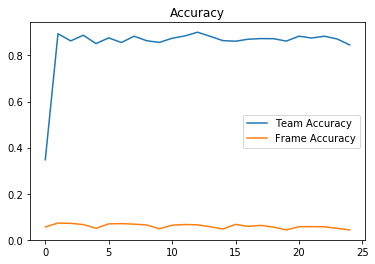

In [52]:
means = []
for l in accuracy:
    l = np.array(l)
#     print(l)
#     l = l[l != None]
    means.append([l[:,0].mean(), l[:, 1].mean()])
plt.plot(range(len(accuracy)), means)
plt.title('Accuracy')
plt.legend(['Team Accuracy', 'Frame Accuracy'])

In [53]:

    input_train, input_test, output_train, output_test = get_train_test_data(proto, df)

In [54]:
test_output = model(torch.from_numpy(input_test).float().cuda())
output = test_output.cpu().detach().numpy()
team_accuracy = (output[:, 0].round() == output_test[:, 0]).sum() / output.shape[0]
frame_accuracy = (abs(output[:, 1] - output_test[:, 1]) < 30 * 1).sum() / output.shape[0]
team_accuracy, frame_accuracy

(0.9404296875, 0.02001953125)

Text(0, 0.5, 'predicted')

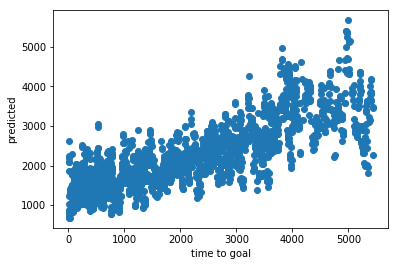

In [56]:
plt.scatter(output_test[output_test[:,1] > 0][:, 1], output[output_test[:,1] > 0][:, 1]);
plt.xlabel('time to goal')
plt.ylabel('predicted')